In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


In [5]:
# load images and flat labels  

from collections import Counter

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

flatLabelDict = Counter()

labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())

	flatLableTuple = tuple([f"{label}_{cellShape}_{nucleusShape}_{cytoplasmVacuole}" for label in labelTuple for cellShape in cellShapeTuple for nucleusShape in nucleusShapeTuple for cytoplasmVacuole in cytoplasmVacuoleTuple])

	for imgLabel in csvItems:
		key = f"{imgLabel['label']}_{imgLabel['cell_shape']}_{imgLabel['nucleus_shape']}_{imgLabel['cytoplasm_vacuole']}"

		flatLabelDict[key] += 1
		allLabelDict[imgLabel['imageID']] = labelTuple.index(imgLabel['label'])


print(len(flatLableTuple))
print(flatLabelDict)
print(labelDict)
print(cellShapeDict)
print(nucleusShapeDict)
print(cytoplasmVacuoleDict)

120
Counter({'Eosinophil_round_segmented-bilobed_no': 956, 'Neutrophil_round_unsegmented-band_no': 883, 'Lymphocyte_round_unsegmented-round_no': 314, 'Eosinophil_round_segmented-multilobed_no': 261, 'Monocyte_round_unsegmented-indented_no': 248, 'Basophil_round_irregular_no': 237, 'Neutrophil_round_segmented-bilobed_no': 212, 'Neutrophil_irregular_unsegmented-band_no': 180, 'Basophil_round_segmented-bilobed_no': 144, 'Eosinophil_round_unsegmented-band_no': 140, 'Lymphocyte_irregular_unsegmented-round_no': 138, 'Monocyte_irregular_unsegmented-indented_yes': 137, 'Neutrophil_round_segmented-multilobed_no': 132, 'Basophil_round_segmented-multilobed_no': 117, 'Monocyte_irregular_irregular_yes': 102, 'Monocyte_irregular_unsegmented-indented_no': 91, 'Lymphocyte_round_unsegmented-indented_no': 77, 'Neutrophil_irregular_segmented-multilobed_no': 69, 'Eosinophil_irregular_segmented-bilobed_no': 68, 'Neutrophil_irregular_segmented-bilobed_no': 65, 'Monocyte_round_unsegmented-indented_yes': 41, 

In [105]:
import os
import shutil

for file_name in imageFileNames:
	file_name = file_name.numpy().decode("utf-8")
	key = os.path.basename(file_name)[:9]
	
	os.makedirs(f"./sorted-images/{allLabelDict[key]}", exist_ok=True)
	shutil.copy(file_name, f"./sorted-images/{allLabelDict[key]}/{key}.jpg")


In [22]:
# load images and labels Old

from collections import Counter

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]


numImages = 5000

classWeights = {
	'label': dict([(i, (1 / labelDict[labelTuple[i]]) * (numImages / 2.0)) for i in range(len(labelTuple))]),
	'cell_shape': dict([(i, (1 / cellShapeDict[cellShapeTuple[i]]) * (numImages / 2.0)) for i in range(len(cellShapeTuple))]),
	'nucleus_shape': dict([(i, (1 / nucleusShapeDict[nucleusShapeTuple[i]]) * (numImages / 2.0)) for i in range(len(nucleusShapeTuple))]),
	'cytoplasm_vacuole': dict([(i, (1 / cytoplasmVacuoleDict[cytoplasmVacuoleTuple[i]]) * (numImages / 2.0)) for i in range(len(cytoplasmVacuoleTuple))])
}

classRandomAcc = {
	'label': sum([(i / numImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(classWeights)
print(classRandomAcc)

print(f'label: {[f"{key}: {value / 50}" for key, value in labelDict.items()]} | {100 / len(labelDict)}')
print(f'cell shape: {[f"{key}: {value / 50}" for key, value in cellShapeDict.items()]} | {100 / len(cellShapeDict)}')
print(f'nuclius shape: {[f"{key}: {value / 50}" for key, value in nucleusShapeDict.items()]} | {100 / len(nucleusShapeDict)}')
print(f'cytoplasm vacuole: {[f"{key}: {value / 50}" for key, value in cytoplasmVacuoleDict.items()]} | {100 / len(cytoplasmVacuoleDict)}')
# print(allLabelDict)

{'label': {0: 4.317789291882556, 1: 3.681885125184094, 2: 3.980891719745223, 3: 1.5527950310559007, 4: 1.6622340425531914}, 'cell_shape': {0: 0.6403688524590164, 1: 2.281021897810219}, 'nucleus_shape': {0: 4.844961240310077, 1: 3.852080123266564, 2: 5.827505827505828, 3: 3.993610223642172, 4: 1.937984496124031, 5: 1.6778523489932884}, 'cytoplasm_vacuole': {0: 0.5389092476826902, 1: 6.925207756232687}}
{'label': 0.24179128, 'cellShape': 0.65769728, 'nucleusShape': 0.20590296, 'cytoplasmVacuole': 0.8660256799999999}
label: ['Lymphocyte: 11.58', 'Monocyte: 13.58', 'Basophil: 12.56', 'Neutrophil: 32.2', 'Eosinophil: 30.08'] | 20.0
cell shape: ['round: 78.08', 'irregular: 21.92'] | 50.0
nuclius shape: ['unsegmented-round: 10.32', 'unsegmented-indented: 12.98', 'irregular: 8.58', 'segmented-multilobed: 12.52', 'unsegmented-band: 25.8', 'segmented-bilobed: 29.8'] | 16.666666666666668
cytoplasm vacuole: ['no: 92.78', 'yes: 7.22'] | 50.0


In [32]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	key = os.path.basename(path)[:9]
	
	if key not in allLabelDict:
		print("Missing key:", key)
		raise ValueError("Missing label key.")
	return tf.convert_to_tensor(allLabelDict[key])

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.int32)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}
	print(labelDict)

	return img, labelDict

def augment(img, label):
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_flip_left_right(img)

    return img, label


valSize = int(imageFileNames.cardinality().numpy() * 0.2)

trainData = imageFileNames \
  .skip(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .batch(10) \
  .prefetch(buffer_size=tf.data.AUTOTUNE) \
  .cache()
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .batch(10) \
  .prefetch(buffer_size=tf.data.AUTOTUNE) \
  .cache()

print(tf.data.experimental.cardinality(trainData).numpy())
print(tf.data.experimental.cardinality(valData).numpy())

for image, label in trainData.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.shape)


{'labelOutput': <tf.Tensor 'packed:0' shape=(1,) dtype=int32>, 'cellShapeOutput': <tf.Tensor 'packed_1:0' shape=(1,) dtype=int32>, 'nucleusShapeOutput': <tf.Tensor 'packed_2:0' shape=(1,) dtype=int32>, 'cytoplasmVacuoleOutput': <tf.Tensor 'packed_3:0' shape=(1,) dtype=int32>}
{'labelOutput': <tf.Tensor 'packed:0' shape=(1,) dtype=int32>, 'cellShapeOutput': <tf.Tensor 'packed_1:0' shape=(1,) dtype=int32>, 'nucleusShapeOutput': <tf.Tensor 'packed_2:0' shape=(1,) dtype=int32>, 'cytoplasmVacuoleOutput': <tf.Tensor 'packed_3:0' shape=(1,) dtype=int32>}
400
100
Image shape:  (10, 360, 360, 3)


2025-08-21 18:15:15.501363: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


AttributeError: 'dict' object has no attribute 'shape'

In [113]:
trainData, valData = tf.keras.utils.image_dataset_from_directory(
  'sorted-images',
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(360, 360),
  batch_size=10
)


trainData = trainData.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valData = valData.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Using 1000 files for validation.


In [14]:
# shit model 

num_classes = 5

model = tf.keras.Sequential([
	tf.keras.Input(shape=(360, 360, 3)),
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 360, 360, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 358, 358, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 179, 179, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 177, 177, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 86, 86, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 59168)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     7,573,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,593,669 (28.97 MB)

 Trainable params: 7,593,669 (28.97 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

baseLayers = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputLayer)
baseLayers = tf.keras.layers.Conv2D(32, 3, activation='relu')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D()(baseLayers)
baseLayers = tf.keras.layers.Conv2D(32, 3, activation='relu')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D()(baseLayers)
baseLayers = tf.keras.layers.Conv2D(32, 3, activation='relu')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D()(baseLayers)
baseLayers = tf.keras.layers.Flatten()(baseLayers)
baseLayers = tf.keras.layers.Dense(128, activation='relu')(baseLayers)

#label 
labelOutput = tf.keras.layers.Dense(len(labelTuple), name='labelOutput')(baseLayers)

# cell shape
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), name='cellShapeOutput')(baseLayers)

# nucleus shape
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), name='nucleusShapeOutput')(baseLayers)

# cytoplasm vacuole
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), name='cytoplasmVacuoleOutput')(baseLayers)

model = tf.keras.Model(
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.compile(
  optimizer='adam',
  loss={
		'labelOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		'cellShapeOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		'nucleusShapeOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		'cytoplasmVacuoleOutput': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	},
  metrics={
		'labelOutput': 'accuracy',
		'cellShapeOutput': 'accuracy',
		'nucleusShapeOutput': 'accuracy',
		'cytoplasmVacuoleOutput': 'accuracy'
	},
)

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 360, 360,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 358, 358,  │        896 │ rescaling_9[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 179, 179,  │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 177, 177,  │      9,248 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 88, 88,    │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 86, 86,    │      9,248 │ max_pooling2d_25… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 43, 43,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 59168)     │          0 │ max_pooling2d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │  7,573,632 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │        258 │ dense_28[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │        258 │ dense_28[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        645 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        774 │ dense_28[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,594,959 (28.97 MB)

 Trainable params: 7,594,959 (28.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# image net base 
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))
inputLayer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputLayer)

baseModel = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(360, 360, 3),
    include_top=False
)

baseModel.trainable = False

baseLayers = baseModel(inputLayer, training=False)
baseLayers = tf.keras.layers.GlobalAveragePooling2D()(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)
labelOutput = tf.keras.layers.Dense(5, name='flatLabelOutput')(baseLayers)


model = tf.keras.Model(
	inputs=inputLayer, 
	outputs=labelOutput
)

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_1150CLONE          │ (None, 360, 360, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 12, 12, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatLabelOutput (Dense)         │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,997,101 (80.10 MB)

 Trainable params: 135,621 (529.77 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [79]:
# clean 

for layer in model.layers:
	if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'kernel'):
		layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape, dtype=layer.kernel.dtype))
	if hasattr(layer, 'bias_initializer') and hasattr(layer, 'bias'):
		layer.bias.assign(layer.bias_initializer(layer.bias.shape, dtype=layer.bias.dtype))

tf.keras.backend.clear_session(free_memory=True)


In [33]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=4,
  batch_size=10
)


Epoch 1/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - cellShapeOutput_accuracy: 0.8185 - cellShapeOutput_loss: 0.4349 - cytoplasmVacuoleOutput_accuracy: 0.9450 - cytoplasmVacuoleOutput_loss: 0.1601 - labelOutput_accuracy: 0.8745 - labelOutput_loss: 0.3467 - loss: 1.9339 - nucleusShapeOutput_accuracy: 0.6047 - nucleusShapeOutput_loss: 0.9922 - val_cellShapeOutput_accuracy: 0.8320 - val_cellShapeOutput_loss: 0.4165 - val_cytoplasmVacuoleOutput_accuracy: 0.9400 - val_cytoplasmVacuoleOutput_loss: 0.1642 - val_labelOutput_accuracy: 0.8900 - val_labelOutput_loss: 0.3200 - val_loss: 1.9840 - val_nucleusShapeOutput_accuracy: 0.5610 - val_nucleusShapeOutput_loss: 1.0833
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - cellShapeOutput_accuracy: 0.8528 - cellShapeOutput_loss: 0.3485 - cytoplasmVacuoleOutput_accuracy: 0.9597 - cytoplasmVacuoleOutput_loss: 0.1223 - labelOutput_accuracy: 0.9175 - labelOutput_loss: 0.2228 - loss: 1.4774 - nucleusShapeOutput_accuracy: 0.6957 - nucleusShapeOutpu

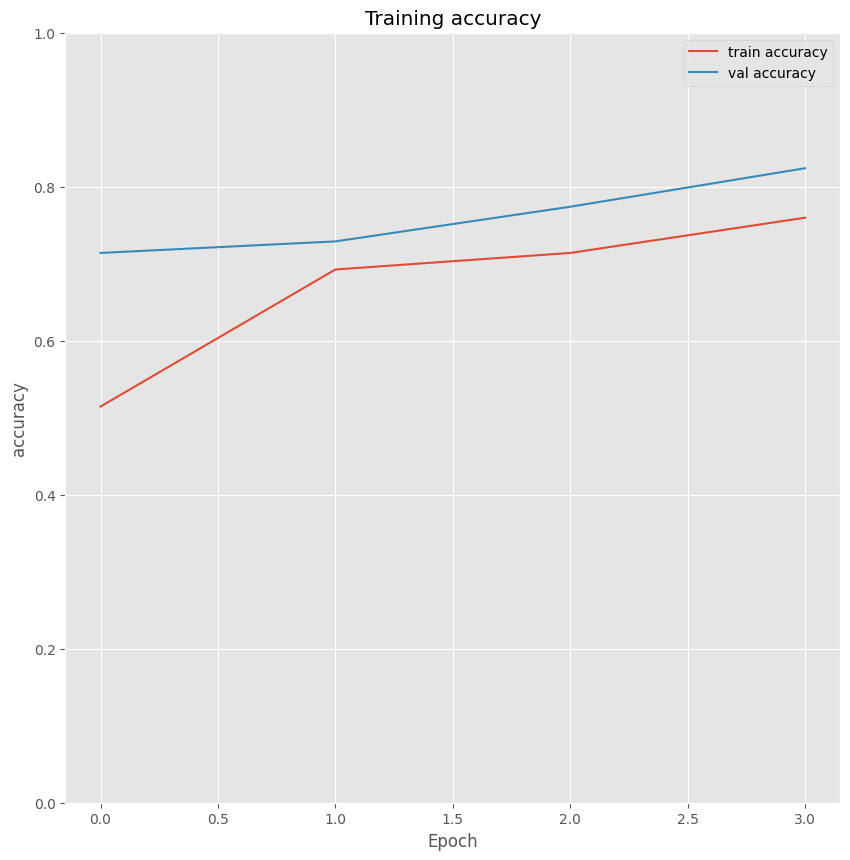

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.5377


{'accuracy': 0.8240000009536743, 'loss': 0.5377327799797058}

In [20]:
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
Nepoch=len(history.epoch)

plt.plot(np.arange(0, Nepoch), history.history['accuracy'], label='train accuracy')

plt.plot(np.arange(0, Nepoch), history.history['val_accuracy'], label='val accuracy')

plt.title(f"Training accuracy")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc="upper right") 

plt.show()

model.evaluate(valData, return_dict=True)


label 0.8560000061988831
cellShape 0.8100000023841858
nucleusShape 0.4729999899864197
cytoplasmVacuole 0.8849999904632568


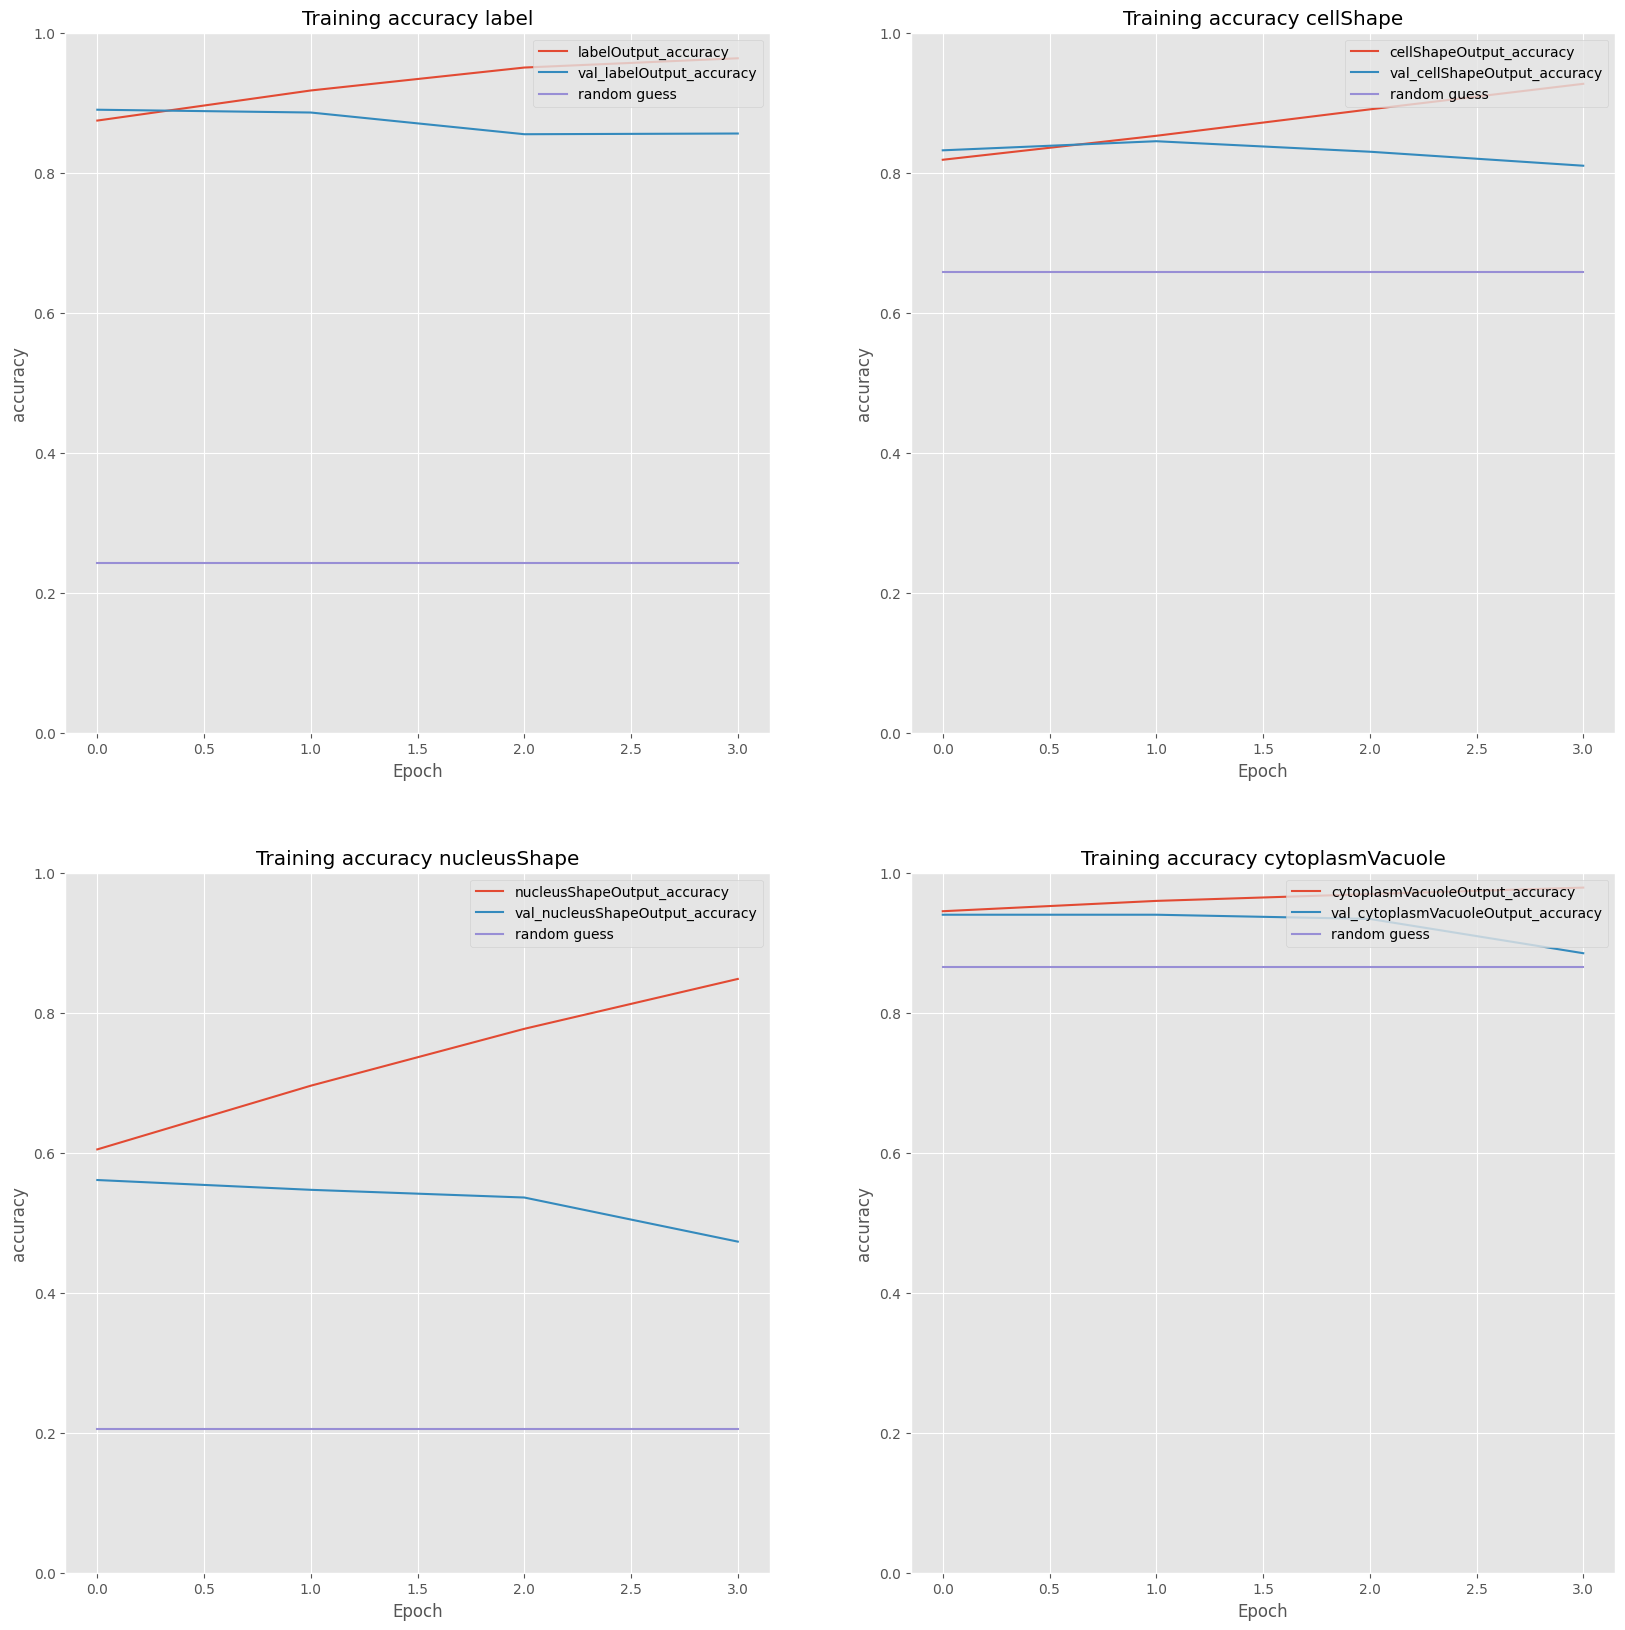

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cellShapeOutput_accuracy: 0.8100 - cellShapeOutput_loss: 0.5497 - cytoplasmVacuoleOutput_accuracy: 0.8850 - cytoplasmVacuoleOutput_loss: 0.2965 - labelOutput_accuracy: 0.8560 - labelOutput_loss: 0.4554 - loss: 3.1012 - nucleusShapeOutput_accuracy: 0.4730 - nucleusShapeOutput_loss: 1.7996


{'cellShapeOutput_accuracy': 0.8100000023841858,
 'cellShapeOutput_loss': 0.5497174859046936,
 'cytoplasmVacuoleOutput_accuracy': 0.8849999904632568,
 'cytoplasmVacuoleOutput_loss': 0.29650330543518066,
 'labelOutput_accuracy': 0.8560000061988831,
 'labelOutput_loss': 0.45535561442375183,
 'loss': 3.1012156009674072,
 'nucleusShapeOutput_accuracy': 0.4729999899864197,
 'nucleusShapeOutput_loss': 1.7996386289596558}

In [34]:
# old plot

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

i = 0
for outLabel in ['label', 'cellShape', 'nucleusShape', 'cytoplasmVacuole']:
	i += 1
	plt.subplot(2,2,i)
	trainKey = f'{outLabel}Output_accuracy'
	testKey = f'val_{trainKey}'
	
	plt.plot(np.arange(0, Nepoch), history.history[trainKey], label=trainKey)

	plt.plot(np.arange(0, Nepoch), history.history[testKey], label=testKey)
	plt.plot(np.arange(0, Nepoch), [classRandomAcc[outLabel] for i in range(Nepoch)], label='random guess')		

	plt.title(f"Training accuracy {outLabel}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="upper right") 

	print(f'{outLabel} {history.history[testKey][-1]}')

plt.show()

model.evaluate(valData, return_dict=True)
